# Add Variable Modeling

## 1. setting modules

In [110]:
# load modules
import numpy as np
import pandas as pd

# split
from sklearn.model_selection import train_test_split

# models 
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# vif
from statsmodels.stats.outliers_influence import variance_inflation_factor

# visualization
from matplotlib import pyplot as plt

# metrics
from sklearn.metrics import mean_squared_log_error

In [51]:
# load data
train = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test.csv')
add = pd.read_csv('../Data/another_factor.csv', encoding = 'cp949')

In [52]:
# 필요한 데이터만 가져오기
use_train = train[['사고일시', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '시군구', '사망자수']]
use_test = test[test.columns.difference(['ID'])]

## 2. data preprocessing

In [53]:
# one hot encoding
onehot = pd.get_dummies(use_train[['기상상태', '도로형태', '노면상태', '사고유형']], drop_first=True)
use_train2 = pd.concat([use_train, onehot], axis = 1).drop(['기상상태', '도로형태', '노면상태', '사고유형'], axis = 1)

onehot_test = pd.get_dummies(test[['기상상태', '도로형태', '노면상태', '사고유형']], drop_first=True)
use_test2 = pd.concat([use_test, onehot_test], axis = 1).drop(['기상상태', '도로형태', '노면상태', '사고유형'], axis = 1)

In [54]:
# 요일 월~금: 0 토~일:1
use_train2['주말'] = np.where(use_train2['요일'].isin(['월요일', '화요일', '수요일', '목요일', '금요일']), 0, 1)
use_train3 = use_train2.drop(['요일'], axis = 1)

use_test2['주말'] = np.where(use_test2['요일'].isin(['월요일', '화요일', '수요일', '목요일', '금요일']), 0, 1)
use_test3 = use_test2.drop(['요일'], axis = 1)

In [55]:
# 사고일시 나누기

## date type data
use_train3['사고일시'] = pd.to_datetime(use_train3['사고일시'])
use_test3['사고일시'] = pd.to_datetime(use_test3['사고일시'])

In [56]:
# split year, month, day, hour
use_train3['year'] = use_train3['사고일시'].dt.year
use_train3['month'] = use_train3['사고일시'].dt.month
use_train3['day'] = use_train3['사고일시'].dt.day
use_train3['hour'] = use_train3['사고일시'].dt.hour

use_test3['year'] = use_test3['사고일시'].dt.year
use_test3['month'] = use_test3['사고일시'].dt.month
use_test3['day'] = use_test3['사고일시'].dt.day
use_test3['hour'] = use_test3['사고일시'].dt.hour

In [57]:
# 시군구 나누기
use_train3[['시', '구', '동가']] = use_train3['시군구'].str.split(' ', expand = True)
use_train4 = use_train3.drop(['사고일시', '시군구', '시', 'year'], axis = 1)

use_test3[['시', '구', '동가']] = use_test3['시군구'].str.split(' ', expand = True)
use_test4 = use_test3.drop(['사고일시', '시군구', '시', 'year'], axis = 1)

In [58]:
# 안개 없기 때문에 0
use_test4['기상상태_안개'] = 0

In [59]:
# 추가변수 붙여넣기
use_train5 = pd.merge(use_train4, add, how = 'left', on = '동가')
use_test5 = pd.merge(use_test4, add, how = 'left', on = '동가')

In [60]:
# 결측치는 0으로
use_train5[add.columns] = use_train5[add.columns].fillna(0)
use_test5[add.columns] = use_test5[add.columns].fillna(0)

In [61]:
# type change - 상혁
use_train4['구'] = use_train4['구'].astype('category')
use_train4['동가'] = use_train4['동가'].astype('category')

use_test4['구'] = use_test4['구'].astype('category')
use_test4['동가'] = use_test4['동가'].astype('category')

In [62]:
# type change - 상혁
use_train5['구'] = use_train5['구'].astype('category')
use_train5['동가'] = use_train5['동가'].astype('category')

use_test5['구'] = use_test5['구'].astype('category')
use_test5['동가'] = use_test5['동가'].astype('category')

In [120]:
tmp = use_train5.drop(['구', '동가'], axis = 1).astype('int64')

In [121]:
tmp

,사망자수,기상상태_눈,기상상태_맑음,기상상태_비,기상상태_안개,기상상태_흐림,도로형태_교차로 - 교차로안,도로형태_교차로 - 교차로횡단보도내,도로형태_기타 - 기타,도로형태_단일로 - 고가도로위,...,month,day,hour,보호구역,불법주정차,차량전용,평지도로,설치개수,주차장개수,어린이보호구역개수
0,0,0,1,0,0,0,0,0,0,0,...,1,1,0,1,4,0,0,391,11,2
1,0,0,0,0,0,1,0,0,0,0,...,1,1,0,1,8,0,3,941,4,0
2,0,0,1,0,0,0,0,0,0,0,...,1,1,1,0,0,0,4,473,0,5
3,0,0,1,0,0,0,0,0,0,0,...,1,1,2,7,0,0,3,534,14,11
4,0,0,1,0,0,0,0,0,0,0,...,1,1,4,7,0,0,5,2064,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,0,0,1,0,0,0,1,0,0,0,...,12,31,19,1,0,0,0,0,0,1
39605,0,0,1,0,0,0,0,0,0,0,...,12,31,19,11,12,3,4,844,5,0
39606,0,0,1,0,0,0,1,0,0,0,...,12,31,21,4,13,0,5,167,1,0
39607,0,0,1,0,0,0,0,0,1,0,...,12,31,22,0,0,0,1,210,1,0


In [122]:
# VIF 출력을 위한 데이터 프레임 형성
vif = pd.DataFrame()

# VIF 값과 각 Feature 이름에 대해 설정
vif["VIF Factor"] = [variance_inflation_factor(tmp.values, i) for i in range(tmp.shape[1])]
vif["features"] = tmp.columns 

# VIF 값이 높은 순으로 정렬
vif = vif.sort_values(by="VIF Factor", ascending=False)
vif = vif.reset_index().drop(columns='index')
vif

,VIF Factor,features
0,25.449594,기상상태_맑음
1,11.995891,평지도로
2,10.131327,기상상태_비
3,8.706038,노면상태_젖음/습기
4,7.171153,어린이보호구역개수
5,7.131516,hour
6,6.097814,사고유형_차대차
7,5.438629,설치개수
8,4.833869,month
9,4.408869,도로형태_단일로 - 기타


## 3. Modeling

In [99]:
## 3. hold-out train test split
x_train, x_valid, y_train, y_valid = train_test_split(use_train5[use_train5.columns.difference(['사망자수'])],
                                                      use_train5['사망자수'],
                                                      test_size = 0.3,
                                                      random_state = 42
                                                    )

In [100]:
# category values
labels = x_train.dtypes.reset_index()
categorical_cols = list(labels[labels[0] == 'category'].index)

In [101]:
# model
xgb = XGBRegressor(objective='count:poisson',
                    random_state = 42,
                    use_label_encoder=False,
                    enable_categorical=True,
                    tree_method='hist'
                    )
lgbm = LGBMRegressor(
    objective='poisson',
    random_state = 42
)
cb = CatBoostRegressor(
    cat_features = categorical_cols,
    objective = 'Poisson',
    random_state = 42
)

In [102]:
# fitting
xgb.fit(x_train, y_train)
lgbm.fit(x_train, y_train)
cb.fit(x_train, y_train,
        eval_set=(x_valid, y_valid),
        use_best_model = True,
        plot = True)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 527
[LightGBM] [Info] Number of data points in the train set: 27726, number of used features: 29
[LightGBM] [Info] Start training from score -4.887792


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8644793	test: 0.8646294	best: 0.8646294 (0)	total: 148ms	remaining: 2m 27s
1:	learn: 0.7510925	test: 0.7513530	best: 0.7513530 (1)	total: 202ms	remaining: 1m 40s
2:	learn: 0.6487305	test: 0.6490197	best: 0.6490197 (2)	total: 256ms	remaining: 1m 25s
3:	learn: 0.5687633	test: 0.5691823	best: 0.5691823 (3)	total: 310ms	remaining: 1m 17s
4:	learn: 0.5011624	test: 0.5016879	best: 0.5016879 (4)	total: 393ms	remaining: 1m 18s
5:	learn: 0.4423703	test: 0.4430581	best: 0.4430581 (5)	total: 578ms	remaining: 1m 35s
6:	learn: 0.3932687	test: 0.3940489	best: 0.3940489 (6)	total: 658ms	remaining: 1m 33s
7:	learn: 0.3511234	test: 0.3519950	best: 0.3519950 (7)	total: 723ms	remaining: 1m 29s
8:	learn: 0.3146073	test: 0.3155380	best: 0.3155380 (8)	total: 906ms	remaining: 1m 39s
9:	learn: 0.2831901	test: 0.2842405	best: 0.2842405 (9)	total: 1000ms	remaining: 1m 38s
10:	learn: 0.2559533	test: 0.2570941	best: 0.2570941 (10)	total: 1.13s	remaining: 1m 41s
11:	learn: 0.2318385	test: 0.2330478	bes

In [103]:
# predict
pred_xgb = xgb.predict(x_valid)
pred_lgbm = lgbm.predict(x_valid)
pred_cb = cb.predict(x_valid)

In [104]:
# metrics
rmsle_xgb = mean_squared_log_error(y_valid, pred_xgb, squared = False)
rmsle_lgbm = mean_squared_log_error(y_valid, pred_lgbm, squared = False)
rmsle_cb = mean_squared_log_error(y_valid, pred_cb, squared = False)

print(f'xgboost : {rmsle_xgb}')
print(f'lightgbm : {rmsle_lgbm}')
print(f'catboost : {rmsle_cb}')

xgboost : 0.06541692009056953
lightgbm : 0.06561033447613245
catboost : 0.06299225799554078


In [108]:
# catboost feature importance
importances = cb.get_feature_importance(type='PredictionValuesChange')
feature_importances = pd.Series(importances, index=x_train.columns).sort_values()

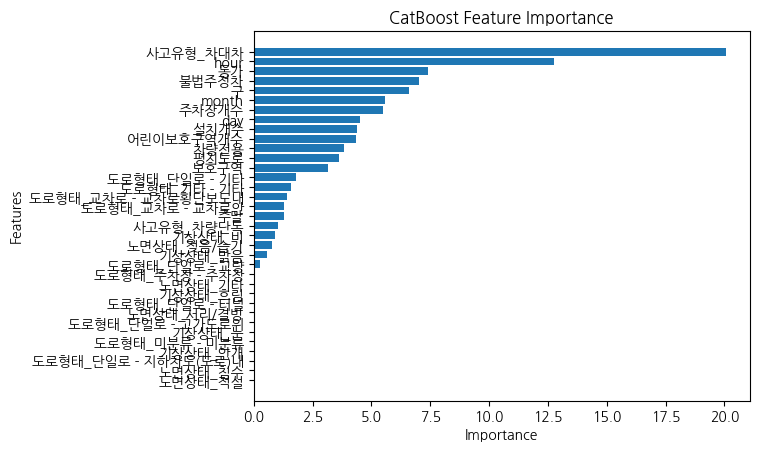

In [109]:
# graph
plt.barh(feature_importances.index, feature_importances.values)

plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')

plt.show()

Baseline
- xgboost : 0.06535774685603425
- lightgbm : 0.06426787080362707
- catboost : 0.06283688668842609

extend variables


In [44]:
# 성능이 가장 좋은 test값 산출하기
pred_test = cb.predict(use_test4[x_train.columns])

In [294]:
# submission 만들기
sample_submission = pd.read_csv('../Data/sample_submission.csv')
baseline_submission = sample_submission.copy()
baseline_submission['사망자수'] = pred_test
baseline_submission.to_csv('../Data/baseline_사망자수.csv', index = False, encoding = 'cp949')